# Getting Started with Qiskit

Here, we provide an overview of working with Qiskit.  The fundamental package of Qiskit is Terra that provides the basic building blocks necessary to program quantum computers. The fundamental unit of Qiskit is the [quantum circuit](https://en.wikipedia.org/wiki/Quantum_circuit). A basic workflow using Qiskit consists of two stages: **Build** and **Execute**. **Build** allows you to make different quantum circuits that represent the problem you are solving, and **Execute** that allows you to run them on different backends.  After the jobs have been run, the data is collected and postprocessed depending on the desired output.

In [32]:
import numpy as np

from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

#Loading the Ibm account

provider = IBMQ.load_account()

from qiskit import *


ibmqfactory.load_account:WARNING:2022-01-21 16:20:28,971: Credentials are already in use. The existing account in the session will be replaced.


In [33]:
available_cloud_backends = provider.backends()
print('\n Here is the list of cloud backends that are available to you :')
for i in available_cloud_backends: print(i)

available_local_backends=Aer.backends()
print('\nHere is the list of local backends that are available to you: ')
for i in available_local_backends: print(i)


 Here is the list of cloud backends that are available to you :
ibmq_qasm_simulator
ibmq_armonk
ibmq_santiago
ibmq_bogota
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila

Here is the list of local backends that are available to you: 
aer_simulator
aer_simulator_statevector
aer_simulator_density_matrix
aer_simulator_stabilizer
aer_simulator_matrix_product_state
aer_simulator_extended_stabilizer
aer_simulator_unitary
aer_simulator_superop
qasm_simulator
statevector_simulator
unitary_simulator
pulse_simulator


## Circuit Basics <a name='basics'></a>


### Building the circuit

The basic element needed for your first program is the QuantumCircuit.  We begin by creating a `QuantumCircuit` comprised of three qubits.

After you create the circuit with its registers, you can add gates ("operations") to manipulate the registers. As you proceed through the tutorials you will find more gates and circuits; below is an example of a quantum circuit that makes a three-qubit GHZ state

$$|\psi\rangle = \left(|000\rangle+|111\rangle\right)/\sqrt{2}.$$

To create such a state, we start with a three-qubit quantum register. By default, each qubit in the register is initialized to $|0\rangle$. To make the GHZ state, we apply the following gates:
- A Hadamard gate $H$ on qubit 0, which puts it into the superposition state $\left(|0\rangle+|1\rangle\right)/\sqrt{2}$.
- A controlled-Not operation ($C_{X}$) between qubit 0 and qubit 1.
- A controlled-Not operation between qubit 0 and qubit 2.

On an ideal quantum computer, the state produced by running this circuit would be the GHZ state above.

In Qiskit, operations can be added to the circuit one by one, as shown below.

In [34]:
circ = QuantumCircuit(1,1)
circ.h(0)
meas=QuantumCircuit(1,1)
meas.measure(0,0)
qc = circ.compose(meas)

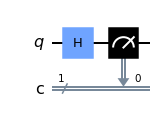

In [35]:
qc.draw()

In [36]:
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = backend_sim.run(transpile(qc,backend_sim),shots=10000)
result = job_sim.result()
counts = result.get_counts(qc)
print(counts)
if counts.get('0')==1:
    print('It is a No Work day')
else:
    print('It is a Work day!')

{'1': 4922, '0': 5078}
It is a Work day!


In [40]:
real_device = provider.get_backend('ibmq_belem')
job = real_device.run(transpile(qc,real_device),shots=3000)
result = job.result()
counts = result.get_counts(qc)
print(counts)
if counts.get('0')==1:
    print('It is a No Work day!')
else:
    print('It is a Work Day!')

{'0': 1604, '1': 1396}
It is a Work Day!


The simulators above are useful because they provide information about the state output by the ideal circuit and the matrix representation of the circuit. However, a real experiment terminates by _measuring_ each qubit (usually in the computational $|0\rangle, |1\rangle$ basis). Without measurement, we cannot gain information about the state. Measurements cause the quantum system to collapse into classical bits. 

For example, suppose we make independent measurements on each qubit of the three-qubit GHZ state

$$|\psi\rangle = (|000\rangle +|111\rangle)/\sqrt{2},$$

and let $xyz$ denote the bitstring that results. Recall that, under the qubit labeling used by Qiskit, $x$ would correspond to the outcome on qubit 2, $y$ to the outcome on qubit 1, and $z$ to the outcome on qubit 0. 

<div class="alert alert-block alert-info">
<b>Note:</b> This representation of the bitstring puts the most significant bit (MSB) on the left, and the least significant bit (LSB) on the right. This is the standard ordering of binary bitstrings. We order the qubits in the same way (qubit representing the MSB has index 0), which is why Qiskit uses a non-standard tensor product order.
</div>

Recall the probability of obtaining outcome $xyz$ is given by

$$\mathrm{Pr}(xyz) = |\langle xyz | \psi \rangle |^{2}$$

and as such for the GHZ state probability of obtaining 000 or 111 are both 1/2.

To simulate a circuit that includes measurement, we need to add measurements to the original circuit above, and use a different Aer backend.

In [13]:
# Create a Quantum Circuit
meas = QuantumCircuit(3, 3)
meas.barrier(range(3))
# map the quantum measurement to the classical bits
meas.measure(range(3), range(3))

# The Qiskit circuit object supports composition using
# the addition operator.
circ.add_register(meas.cregs[0])
qc = circ.compose(meas)

#drawing the circuit
qc.draw()

┌───┐           ░ ┌─┐      
q_0: ┤ H ├──■────■───░─┤M├──────
     └───┘┌─┴─┐  │   ░ └╥┘┌─┐   
q_1: ─────┤ X ├──┼───░──╫─┤M├───
          └───┘┌─┴─┐ ░  ║ └╥┘┌─┐
q_2: ──────────┤ X ├─░──╫──╫─┤M├
               └───┘ ░  ║  ║ └╥┘
c: 3/═══════════════════╩══╩══╩═
                        0  1  2

This circuit adds a classical register, and three measurements that are used to map the outcome of qubits to the classical bits. 

To simulate this circuit, we use the ``qasm_simulator`` in Qiskit Aer. Each run of this circuit will yield either the bitstring 000 or 111. To build up statistics about the distribution of the bitstrings (to, e.g., estimate $\mathrm{Pr}(000)$), we need to repeat the circuit many times. The number of times the circuit is repeated can be specified in the ``execute`` function, via the ``shots`` keyword.

In [17]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

Once you have a result object, you can access the counts via the function `get_counts(circuit)`. This gives you the _aggregated_ binary outcomes of the circuit you submitted.

In [18]:
counts = result_sim.get_counts(qc)
print(counts)

{'111': 514, '000': 510}


Approximately 50 percent of the time, the output bitstring is 000. Qiskit also provides a function `plot_histogram`, which allows you to view the outcomes. 

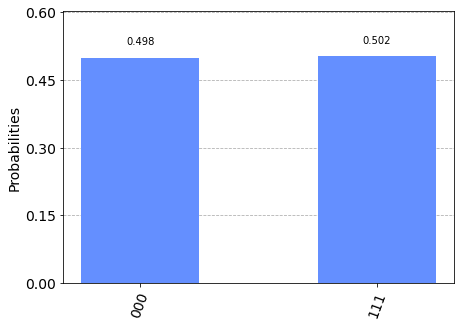

In [19]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

The estimated outcome probabilities $\mathrm{Pr}(000)$ and  $\mathrm{Pr}(111)$ are computed by taking the aggregate counts and dividing by the number of shots (times the circuit was repeated). Try changing the ``shots`` keyword in the ``execute`` function and see how the estimated probabilities change.

In [20]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright